In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import KFold
#import nonechucks as nc

In [3]:

from __future__ import print_function, division
import os
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [7]:


import os
import cv2
from PIL import Image
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
#from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,RandomRotate90,Transpose,RandomBrightnessContrast)
from albumentations.pytorch import ToTensor
import albumentations as albu
import matplotlib.image as mpi
warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
!pip install albumentations

     |████████████████████████████████| 3.2MB 408kB/s eta 0:00:01
     |████████████████████████████████| 634kB 13.1MB/s eta 0:00:01
     |████████████████████████████████| 28.3MB 3.3MB/s eta 0:00:011
  Created wheel for albumentations: filename=albumentations-0.4.3-cp37-none-any.whl size=60766 sha256=e5aceb384780f38f1f42ce7641242c26159f799b56382bb11f1a38bd7e73d2d1
  Stored in directory: /home/sachin/.cache/pip/wheels/20/16/8e/d3bec34bf30adff30929226f0b83cc8c005b5af131f51db9d0
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654021 sha256=e043d734bbe9947aed80588af020ad539baedd05e1b7879721208b42d6a69aa0
  Stored in directory: /home/sachin/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: opencv-python 4.0.0.21
    Uninstalling opencv-python-4.0.0.21:
      Successfully uninstalled opencv-python-4.0.0.21
You should consider upgrading via the 'pip install --upgrade p

In [6]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-vxqbjlgv
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-vxqbjlgv
     |████████████████████████████████| 61kB 383kB/s eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp37-none-any.whl size=46915 sha256=6be15aa9f5a0ae29d271187c0d41c28d8e030c67952330a71f2ef2a5549432fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-apgovmbe/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=c780c5e7053fe61a0fb0467e366505e47519ac98c5ebc14cd44d9837a2ca83e8
  Stored in directory: /home/sachin/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp37-none-any.whl size=11767 sha256=e799cfabd

In [ ]:

from ranger import Ranger

In [ ]:
#cd Image_Segmentation

In [ ]:
#from network import *

In [ ]:
#cd ..

In [ ]:
!unzip segmentation_models_pytorch.zip

In [10]:
import segmentation_models_pytorch as smp

In [ ]:
#cd EfficientUnet_PyTorch

In [ ]:
#from efficientunet2 import *

In [ ]:
#cd ..

In [ ]:


#model=get_efficientunet_b4(out_channels=4, concat_input=True, pretrained=True)


In [5]:

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4)'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [26]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id = self.df["IMAGE_ID"].iloc[idx]
        mask_id = self.df["MASK_ID"].iloc[idx]
        #folder = self.df["folder"].iloc[idx]
        
        image_path = os.path.join(self.root,  image_id)
        mask_path = os.path.join(self.root,mask_id)
        img = mpi.imread(image_path)
        mask = mpi.imread(mask_path)
        mask = mask.astype(np.uint8)
        #print(img.shape,mask.shape,image_id)
        if len(mask.shape)>2:
            mask=mask[:,:,0]
        
        mask = mask.reshape((mask.shape[0],mask.shape[1],1))
        #print(mask.shape,img.shape)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 1x4x256x1600
        #print(mask.shape)
        return img, mask

    def __len__(self):
        #return (1000)
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [ 
                HorizontalFlip(),
                #albu.OneOf([
        #albu.RandomContrast(),
        #albu.RandomGamma(),
        #albu.RandomBrightness(),
        #], p=0.3),# only horizontal flip as of now
                            ]
        )
    list_transforms.extend(
        [   Resize(256,320,interpolation=2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=0,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # some preprocessing
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    #df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
    #df['ClassId'] = df['ClassId'].astype(int)
    #df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    #df['defects'] = df.count(axis=1)
    train_df, val_df = train_test_split(df, test_size=0.15, )
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    #image_dataset = nc.SafeDataset(image_dataset)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

In [22]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


In [ ]:
epsilon = 1e-5
smooth = 1.0

def dice_loss(y_true, y_pred,threshold=0.5):
    cl1loss=Dice2(y_pred[:,0,:,:],y_true[:,0,:,:])
    cl2loss=Dice2(y_pred[:,1,:,:],y_true[:,1,:,:])
    cl3loss=Dice2(y_pred[:,2,:,:],y_true[:,2,:,:])
    cl4loss=Dice2(y_pred[:,3,:,:],y_true[:,3,:,:])
    print(cl1loss,cl2loss,cl3loss,cl4loss)
    tloss=0.25*cl1loss+0.32*cl2loss+0.2*cl3loss+0.23*cl4loss
    loss = 1 - tloss
    return loss

def bce_dice_loss(y_true, y_pred,threshold=0.5):
    l1 = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.25,0.32,0.2,0.23]))
    loss = l1( y_pred.permute(0,2,3,1),y_true.permute(0,2,3,1)) 
    print("loss=",loss)
    loss2=dice_loss(y_true, y_pred,threshold)
    loss=loss+loss2
    print("dice=",loss2)
    return loss

def tversky(y_true, y_pred,threshold):
    y_pred=torch.sigmoid(y_pred)
    #print(torch.max(y_pred),torch.min(y_pred))
    #y_pred = (y_pred>threshold).float()
    #y_pred = (y_pred.gt(threshold).float())*torch.ones_like(y_pred)
    y_true_pos = y_true.view(-1)
    y_pred_pos = y_pred.view(-1)
    true_pos = torch.sum(y_true_pos * y_pred_pos).float()
    false_neg = torch.sum(y_true_pos * (1-y_pred_pos)).float()
    false_pos = torch.sum((1-y_true_pos)*y_pred_pos).float()
    
    alpha = 0.7
    val=(true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
    
    return val

def tversky_loss(y_true, y_pred,threshold=0.5):
    return 1 - tversky(y_true,y_pred,threshold)

def focal_tversky(y_true,y_pred,threshold=0.5):
    pt_1 = tversky(y_true, y_pred,threshold)
    
    gamma = 0.75
    return torch.pow((1-pt_1), gamma).float()


In [20]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds
def Dice(y_pred, y_true,threshold=0.5):
    y_pred = (y_pred>threshold).float(
    )
    smooth = 1.
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    
    
    return score

def Dice2(y_pred, y_true,threshold=0.5):
    y_pred = torch.sigmoid(y_pred)
    smooth = 1.0
    y_true_f = y_true.reshape(y_true.shape[0]*y_true.shape[1]*y_true.shape[2])
    y_pred_f = y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]*y_pred.shape[2])
    intersection = torch.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    
    
    return score

def IoU(pred, targs,threshold=0.5):
    pred = (pred>threshold).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        dice=Dice(probability,truth,threshold)

    return dice

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        #preds = predict(probs, self.base_threshold)
        iou = IoU(probs, targets,threshold=0.5)
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        iou = np.nanmean(self.iou_scores)
        return dice, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f " % (epoch_loss, iou, dices))
    return dices, iou



In [ ]:
def tloss(inputs,target,th=0.5):
    dice=np.array(4,)
    for i in range 4:
        
        dice[i], dice_neg, dice_pos, num_neg, num_pos=metric(inputs[:,:,:,i], targets[:,:,:,i], threshold=th, reduction='none')
        if dice[i]>0:
            dice[i]=()
   
         

In [23]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 0
        self.batch_size = {"train": 16, "val": 8}
        #self.accumulation_steps = 8 // self.batch_size['train']
        self.accumulation_steps = 1
        self.lr = 5e-4
        self.num_epochs = 10
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        #self.criterion = lossfu( alpha=0.7, beta=0.3, gamma=(4/3), weights=None)
        self.criterion = torch.nn.BCEWithLogitsLoss()#pos_weight=torch.tensor([3.0,6.0,1.5,3.0]))
        #self.optimizer = Ranger(self.net.parameters(),lr=self.lr, alpha=0.5, k=6, N_sma_threshhold=5, betas=(.95,0.999), eps=1e-5, weight_decay=0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        #self.optimizer = torch.optim.SGD(model.parameters(), lr=self.lr, momentum=0.9)
        self.scheduler = ReduceLROnPlateau(self.optimizer,factor=0.33, mode="min", patience=2, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        #print(data_folder,train_df_path)
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        #print(outputs.shape)
        
        #print(masks.shape)
        #outputs=outputs["out"]
        loss = self.criterion(outputs.permute(0,2,3,1), masks.permute(0,2,3,1))
        #loss = focal_tversky(masks,outputs,threshold=0.5)
        #loss = bce_dice_loss(masks, outputs,threshold=0.5)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0):
            # replace `dataloader` with `tk0` for tqdm
                   
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./skyres182.pth")
            print()            

In [24]:
#sample_submission_path = 'severstal-steel-defect-detection/sample_submission.csv'
train_df_path = 'all_data2.csv'
data_folder = "data/"
#test_data_folder = "severstal-steel-defect-detection/test_images"


In [11]:
model = smp.Unet('resnet18', classes=1, activation=None,encoder_weights=None)

In [ ]:
#!pip install efficientunet-pytorch

In [ ]:
#from efficientunet import *

In [ ]:
3model = get_efficientunet_b4(out_channels=4, concat_input=True, pretrained=False)

In [ ]:
i=0
for  name,param in model.encoder.named_parameters():
    i+=1
    param.requires_grad=False
    if(i==108):
        break
    #print(i,name)

In [ ]:
device = torch.device("cuda")
model.to(device)

In [18]:
!ls

 1409.1556.pdf
 1409.4842.pdf
 1916171300_PRIMARY.pdf
'1916171300_UPPER PRIMARY.pdf'
 20130101_084634.jpg
'Advanced Engineering Mathematics 10th Edition pdf.pdf'
 Autonomous%20driving%20application%20-%20Car%20detection%20-%20v1.ipynb.zip
'Balaguruswamy Object Oriented Programming With C-- Fourth Edition.pdf'
'Balaguruswamy OOP with C++ ( PDFDrive.com ).pdf'
'Bert-base TF2.0 (minimalistic).ipynb'
 bert-master.zip
 cleaned_data.csv
 cloud.ipynb
 clrs.pdf
 Copy_of_DSFest2020.txt
 CS231-master.zip
 DS-Assignment2_157262823210893853045dbc6708bcd9f.pdf
 DSFest2020.txt
 dsfestcleanedtest.csv
 dsfestcleanedtrain.csv
 EfficientNet-PyTorch-master.zip
'EfficientUnet-PyTorch-master (1).zip'
 EfficientUnet-PyTorch-master.zip
 Extra.csv
 firefox
 gcp_setup.sh
 gdrive-linux-x64
'Gradesheet_18JE0705 (1).pdf'
'Gradesheet_18JE0705 (2).pdf'
 Gradesheet_18JE0705.pdf
 gu_net.ipynb
 Hall-Ticket18JE0705.pdf
'Idea ppt.pptx'
 intheheartofthesea2015brripxvidac3-evo-english-79102.zip
'jb_Modules_in_Python (1).p

In [19]:
ckpt_path = "skyres182.pth"
#device = torch.device("cuda")
#model = smp.Unet("resnet18", encoder_weights=None, classes=4, activation=None)
#model.to(device)
#model.eval()
#state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
state = torch.load(ckpt_path, map_location='cpu')# storage, loc: storage)
model.load_state_dict(state["state_dict"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:

model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 12:51:43


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
Starting epoch: 0 | phase: val | ⏰: 13:11:26


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 13:13:55


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
Starting epoch: 1 | phase: val | ⏰: 13:33:36


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 13:36:00


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
Starting epoch: 2 | phase: val | ⏰: 13:54:49


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 13:57:10


Loss: 0.0112 | IoU: nan | dice: 1.0000 | dice_neg: 1.0000 | dice_pos: 0.0000
Starting epoch: 3 | phase: val | ⏰: 14:16:02


IndexError: tuple index out of range

In [28]:
img = mpi.imread('data/10066/20131223_132723.jpg')

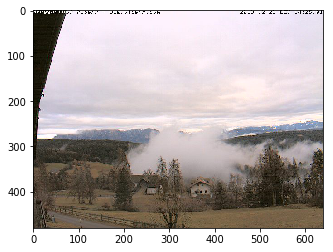

In [29]:
plt.imshow(img)

In [44]:
mask = mpi.imread('data/Masks/10066.png')
mask = cv2.resize(mask,(320,256),interpolation = cv2.INTER_CUBIC)

In [45]:
mask.shape

(256, 320)

In [20]:
def get_transforms(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)):
    list_transforms = []
    list_transforms.extend(
        [   Resize(256,320,interpolation=2),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

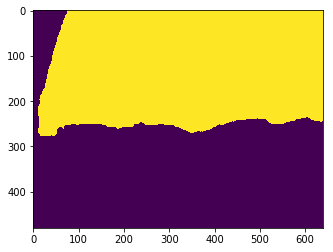

In [31]:
plt.imshow(mask)

In [21]:
transforms = get_transforms()
img = mpi.imread('mountain-winter-reflection-on-lake.jpg')
#if len(mask.shape)>2:
 #           mask=mask[:,:,0]
        #print(mask.shape)
#mask = mask.reshape((mask.shape[0],mask.shape[1],1))

augmented = transforms(image=img)
img = augmented['image']
#print(img.shape[0])
img=img.reshape(1,3,img.shape[1],img.shape[2])
#print(img.shape)
        #mask = augmented['mask'] # 1x256x1600x4
        #mask = mask[0].permute(2, 0, 1)
mage = model.predict(img)
mage2 = torch.sigmoid(mage)

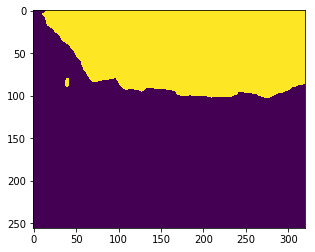

In [31]:
plt.imshow(mage3)

In [30]:
mage2 = mage2.reshape(256,320)
mage3,num  = post_process(mage2,mage2.mean(),50)
mage3=(mage2>(mage2.mean())).astype(int)

In [57]:
mage2.min()

tensor(1.1751e-18)

In [25]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 320), np.int32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

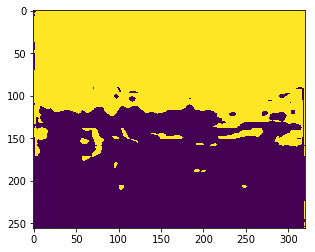

In [72]:
plt.imshow(mage3.cpu().numpy())

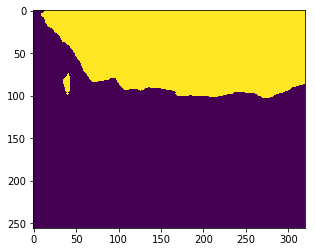

In [80]:
plt.imshow(mage3)

In [9]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-pinn9603
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-pinn9603
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp37-none-any.whl size=46915 sha256=cbc6551b2248d6a1d2388f6c4126da25665cea1e21efc41c52b07da3dbedead4
  Stored in directory: /tmp/pip-ephem-wheel-cache-okeqhuet/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch
You should consider upgrading via the 'pip install --upgrade pip' command.


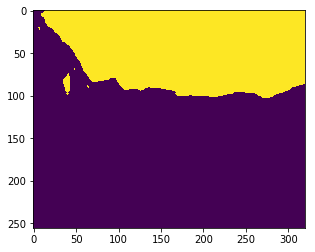

In [70]:
plt.imshow(mage3.cpu().numpy())

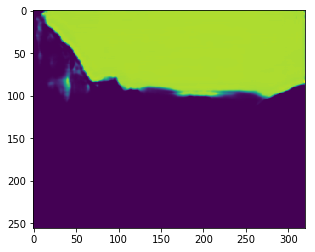

In [55]:
plt.imshow(mage2.cpu().numpy())

In [52]:
(mask==(mage2.cpu().numpy())).sum()

80734

In [ ]:
def get_transforms2():
    list_transforms = []
    list_transforms.extend(
        [   Resize(256,320,interpolation=2),
            #Normalize(mean=mean, std=std, p=1),
            #ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [ ]:
mage2.max()

In [ ]:
mage2.shape

In [ ]:
plt.imshow(mage2.cpu().numpy().reshape(256,320))

In [ ]:
mag = mage2.cpu().numpy().reshape(256,320)

In [ ]:
mag.shape

In [ ]:
mm.shape

In [ ]:
mm

In [ ]:
ai=0
for i in range(256):
    for j in range(320):
        if mm[i][j]==False and mag[i][j]<1e-5:
            ai=ai+1
        elif mm[i][j]==True and mag[i][j]>=1e-5:
            ai = ai+1

In [ ]:
ai

In [ ]:
81920

In [ ]:
mage2=(mage2>1e-5).int()

In [ ]:
mage2.min()

In [ ]:
mage2.max()

In [ ]:
mage2 = mage2.reshape(256,320).cpu().numpy()

In [ ]:
mage2 = mage.sigmo

In [ ]:
plt.imshow(mage2)

In [ ]:
mask=mpi.imread('data/Masks/10066.png')

In [ ]:
import PIL
from PIL import Image

In [ ]:
mask = Image.fromarray(mask)

In [ ]:
maskk = Image.open('data/Masks/10066.png')
maskk = maskk.resize((320,256), PIL.Image.ANTIALIAS)

In [ ]:
mm = np.array(maskk)
print(mm.shape)
plt.imshow(mm)

In [ ]:
mm.dtype=np.uint8()

In [ ]:
mm = mm.astype(int)

In [ ]:
mm2 = torch.as_tensor(mm).int()

In [ ]:
mage2 =torch.as_tensor(mage2).int()

In [ ]:
mm2 = mm2.reshape(320,256)

In [ ]:
(mage2.cpu()==mm2).sum()

In [ ]:
mage2 = mage2.reshape(320,256)

In [ ]:
mage3 = mage2.cpu().numpy()

In [ ]:
mk = mage2.cpu().numpy()

In [ ]:
mm

In [ ]:
plt.imshow(mask2)

In [ ]:
transforms = get_transforms()


In [ ]:
import PIL

In [ ]:
data=pd.read_csv('cleaned_data.csv')

In [ ]:
mask=mask.astype(int)

In [ ]:
mage2.shape

In [ ]:
data.head()

In [ ]:
#set_parameter_requires_grad(model, feature_extracting)
model.classifier[4]=torch.nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4]=torch.nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
i=0
for param in model.parameters():
    param.requires_grad = True
    i+=1
    if i == 312:
        break
    

In [ ]:

model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained=True)


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.backbone.parameters():
            
            param.requires_grad = False

In [ ]:
model = EfficientNet.from_name('efficientnet-b4', n_classes=4, pretrained=True)


In [ ]:
get_efficientunet_b4(out_channels=4, concat_input=True, pretrained=True)

In [ ]:
i=0
for param in model.parameters():
    i+=1
print(i)    

In [ ]:
i=0
for param in model.backbone.parameters():
    #print(param.shape)
    print(i)
    i+=1

In [ ]:
model

In [ ]:
model =  AttU_Net(output_ch=4)

In [ ]:
parallel_model = torch.nn.DataParallel(model)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
model

In [ ]:
feature_extracting=False

In [ ]:
model.backbone

In [ ]:
feature_extracting=True

In [ ]:
device = torch.device("cuda")

In [ ]:
mode = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extracting:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


In [ ]:
parallel_model = torch.nn.DataParallel(model)

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet("resnet18", encoder_weights=None, classes=4, activation=None)


In [ ]:
torch.save(state, "modelfin.pth")

In [ ]:
image_id, mask = make_mask(idx, self.df)
image_path = os.path.join( "severstal-steel-defect-detection/", "train_images",  image_id)
img = cv2.imread(image_path)
  print(img.shape)

In [ ]:
cd sevels

In [ ]:
!mkdir train

In [ ]:
!cp train_images.zip train

In [ ]:
!mkdir test
!cp test_images.zip test

In [ ]:
cd train

In [ ]:
!unzip train_images.zip

In [ ]:
!rm train_images.zip

In [ ]:
import cv2
img=cv2.imread('91e9eaf93.jpg')
print(img)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
cd ..

In [ ]:
!unzip train.csv.zip

In [ ]:
!rm train.csv.zip

In [ ]:
train_label=pd.read_csv('train.csv')

In [ ]:
train_label

In [ ]:
cd train

In [ ]:
import torchvision.models.segmentation

In [ ]:
model=torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21
                                                          , aux_loss=None)

In [ ]:
model.eval()

In [ ]:
from PIL import Image
from torchvision import transforms
input_image = Image.open('0025bde0c.jpg')
print(input_image.size)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.shape)
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)


In [ ]:
label1=train_label['EncodedPixels'][46]
label2=train_label['EncodedPixels'][47]

In [ ]:
import re
str=train_label['ImageId_ClassId'][6]
re.split('_',str)[0]

In [ ]:
length2=int(len(train_label['EncodedPixels'])/4)
length2

In [ ]:
id=[]
for i in range(length):
  str=train_label['ImageId_ClassId'][4*i]
  val=re.split('_',str)[0]
  #print(val)
  id.append(val)
  #id.append(re.split('_',train_label['ImageId_ClassId'][i])[0])

In [ ]:
len(id)

In [ ]:
label1=train_label['EncodedPixels'][4*1]
label1

In [ ]:
label=train_label['EncodedPixels']
label.fillna(value=-1,inplace=True)

In [ ]:
train_label['EncodedPixels']

In [ ]:
output=torch.zeros((1024,256*1600),dtype=torch.int32)
output=output.byte()

In [ ]:
for i in range(0,1024):
  output2=torch.zeros(size=(256*1600,))
  label1=train_label['EncodedPixels'][4*i]
  if label1!=-1:
    #print(i,label1)
    data=label1.split()
    lent=int(len(data)/2)
    start=torch.zeros((lent,),dtype=torch.int)
    length=torch.zeros((lent,),dtype=torch.int)
    for j in range(0,len(data),2):
      start[int(j/2)]=int(data[j])-1
      length[int(j/2)]=int(data[j+1])
    for j in range(0,int(len(data)/2),1):
      output2[start[j]:start[j]+length[j]]=1  
  label2=train_label['EncodedPixels'][4*i+1]
  if label2!=-1:
    #print(i,label2)
    data=label2.split()
    lent=int(len(data)/2)
    start=torch.zeros((lent,),dtype=torch.int)
    length=torch.zeros((lent,),dtype=torch.int)
    for j in range(0,len(data),2):
      start[int(j/2)]=int(data[j])-1
      length[int(j/2)]=int(data[j+1])
    for j in range(0,int(len(data)/2),1):
      output2[start[j]:start[j]+length[j]]=2  
  label3=train_label['EncodedPixels'][4*i+2]
  if label3!=-1:
    #print(i,label3)
    data=label3.split()
    lent=int(len(data)/2)
    start=torch.zeros((lent,),dtype=torch.int)
    length=torch.zeros((lent,),dtype=torch.int)
    for j in range(0,len(data),2):
      start[int(j/2)]=int(data[j])-1
      length[int(j/2)]=int(data[j+1])
    for j in range(0,int(len(data)/2),1):
      output2[start[j]:start[j]+length[j]]=3  
  label4=train_label['EncodedPixels'][4*i+3]
  if label4!=-1:
    #print(i,label4)
    data=label4.split()
    lent=int(len(data)/2)
    start=torch.zeros((lent,),dtype=torch.int)
    length=torch.zeros((lent,),dtype=torch.int)
    for j in range(0,len(data),2):
      start[int(j/2)]=int(data[j])-1
      length[int(j/2)]=int(data[j+1])
    for j in range(0,int(len(data)/2),1):
      output2[start[j]:start[j]+length[j]]=4
    #output3=output2.reshape((1600,256))
    #output3=output3.t()
 
  output[i,:]=output2 

In [ ]:
output=output.numpy()

In [ ]:
output

In [ ]:
pdout=pd.DataFrame(output)

In [ ]:
pdout

In [ ]:
pdout.to_csv('output1.csv')

In [ ]:
ls

In [ ]:
a=5
if a==5:
  print('r')

In [ ]:
torch.sum(output!=0)

In [ ]:
print(i)

In [ ]:
label1

In [ ]:
output2=torch.zeros(size=(256*1600,))

In [ ]:
data=label1.split()

In [ ]:
data2=label2.split()

In [ ]:
lent=int(len(data)/2)
start=torch.zeros((lent,),dtype=torch.int)
length=torch.zeros((lent,),dtype=torch.int)
for i in range(0,len(data),2):
  
  start[int(i/2)]=int(data[i])
  length[int(i/2)]=int(data[i+1])

In [ ]:
lent2=int(len(data2)/2)
start2=torch.zeros((lent2,),dtype=torch.int)
length2=torch.zeros((lent2,),dtype=torch.int)
for i in range(0,len(data2),2):
  
  start2[int(i/2)]=int(data[i])
  length2[int(i/2)]=int(data[i+1])

In [ ]:
start=start.int()

In [ ]:
length=length.int()

In [ ]:
start=start-1
start2=start2-1

In [ ]:
for i in range(0,int(len(data)/2),1):
  output2[start[i]:start[i]+length[i]]=1
for i in range(0,int(len(data2)/2),1):  
  output2[start2[i]:start2[i]+length2[i]]=2

In [ ]:
output3=output2.reshape((1600,256))

In [ ]:
output3=output3.t()

In [ ]:
plt.imshow(input_image)

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output3.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()

In [ ]:
import torchvision

In [ ]:
!pip uninstall torchvision -y

In [ ]:
!pip install torchvision

In [ ]:
!git clone https://github.com/Hsuxu/Loss_ToolBox-PyTorch

In [ ]:
cd Loss_ToolBox-PyTorch

In [ ]:
from TverskyLoss import multitverskyloss

In [ ]:
lossfu=multitverskyloss.MultiTverskyLoss

In [ ]:
cd ..

In [ ]:
!git clone https://github.com/zhoudaxia233/EfficientUnet-PyTorch

In [ ]:
from EfficientUnet_PyTorch import *

In [ ]:
cd EfficientUnet_PyTorch

In [ ]:
ls

In [ ]:
import efficientunet2

In [ ]:
from efficientunet2 import *

In [ ]:
model=get_efficientunet_b4(out_channels=4, concat_input=True, pretrained=True)

In [ ]:
ls

In [ ]:
cd ..

In [ ]:
cd severstal-steel-defect-detection

In [ ]:
!mkdir train_test

In [ ]:
!cp train_images.zip train_test

In [ ]:
!cp test_images.zip train_test

In [ ]:
cd train_test

In [ ]:
!unzip train_images.zip

In [ ]:
!unzip test_images.zip

In [ ]:
!rm train_images.zip

In [ ]:
!rm test_images.zip

In [ ]:
cd '../..'